In [1]:
import os
import pandas as pd
import numpy as np
import pydicom
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import cv2
import glob

In [2]:
!unzip -q /kaggle/input/lsdc-gen-yolo-data-nfn/data_fold0.zip

In [3]:
ls

__notebook__.ipynb  data_fold0/


In [4]:
IMG_DIR = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images"

In [5]:
FOLD = 0
OD_INPUT_SIZE = 384
STD_BOX_SIZE = 20
BATCH_SIZE = 64
EPOCHS = 40

SAMPLE = None
CONDITIONS = ['Left Neural Foraminal Narrowing', 'Right Neural Foraminal Narrowing']
SEVERITIES = ['Normal/Mild', 'Moderate', 'Severe']
LEVELS = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']

DATA_DIR = f'data_fold{FOLD}'



In [6]:
# rm -rf val_fold0

In [7]:
train_val_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
train_xy = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
train_des = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')

In [8]:
if SAMPLE:
    train_val_df = train_val_df.sample(SAMPLE, random_state=2698)

In [9]:
fold_df = pd.read_csv('/kaggle/input/lsdc-fold-split/5folds.csv')

In [10]:
train_xy.head(3)

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182


In [11]:
def get_level(text):
    for lev in ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']:
        if lev in text:
            split = lev.split('_')
            split[0] = split[0].capitalize()
            split[1] = split[1].capitalize()
            return '/'.join(split)
    raise ValueError('Level not found '+ lev)
    
def get_condition(text):
    split = text.split('_')
    for i in range(len(split)):
        split[i] = split[i].capitalize()
    split = split[:-2]
    return ' '.join(split)
#     raise ValueError('Condition not found '+ lev)

In [12]:
train_xy['condition'].unique()

array(['Spinal Canal Stenosis', 'Right Neural Foraminal Narrowing',
       'Left Neural Foraminal Narrowing', 'Left Subarticular Stenosis',
       'Right Subarticular Stenosis'], dtype=object)

In [13]:
# train_df = train_df.dropna()

In [14]:
label_df = {'study_id':[], 'condition': [], 'level':[], 'label':[]}

for i, row in train_val_df.iterrows():
    study_id = row['study_id']
    for k, label in row.iloc[1:].to_dict().items():
        level = get_level(k)
        condition = get_condition(k)
        label_df['study_id'].append(study_id)
        label_df['condition'].append(condition)
        label_df['level'].append(level)
        label_df['label'].append(label)
#         break
#     break

label_df = pd.DataFrame(label_df)
label_df = label_df.merge(fold_df, on='study_id')

In [15]:
train_xy = train_xy.merge(train_des, how='inner', on=['study_id', 'series_id'])
label_df = label_df.merge(train_xy, how='inner', on=['study_id', 'condition', 'level'])

In [16]:
def query_train_xy_row(study_id, series_id=None, instance_num=None):
    if series_id is not None and instance_num is not None:
        return label_df[(label_df.study_id==study_id) & (label_df.series_id==series_id) &
            (label_df.instance_number==instance_num)]
    elif series_id is None and instance_num is None:
        return label_df[(label_df.study_id==study_id)]
    else:
        return label_df[(train_xy.study_id==study_id) & (label_df.series_id==series_id)]

In [17]:
def read_dcm(src_path):
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() +1e-6) * 255
    image = np.stack([image]*3, axis=-1).astype('uint8')
    return image

def get_accronym(text):
    split = text.split(' ')
    return ''.join([x[0] for x in split])

In [18]:
# study_id = 4003253 
# series_id = 2448190387
# instance_num = 28

ex = label_df.sample(1).iloc[0]
study_id = ex.study_id
series_id = ex.series_id
instance_num = ex.instance_number

WIDTH = 10

path = os.path.join(IMG_DIR, str(study_id), str(series_id), f'{instance_num}.dcm')

In [19]:
img = read_dcm(path)

tmp_df = query_train_xy_row(study_id, series_id, instance_num)
for i, row in tmp_df.iterrows():
    lbl = f"{get_accronym(row['condition'])}_{row['level']}"
    x, y = row['x'], row['y']
    x1 = int(x - WIDTH)
    x2 = int(x + WIDTH)
    y1 = int(y - WIDTH)
    y2 = int(y + WIDTH)
    color = None
    if row['label'] == 'Normal/Mild':
        color =  (0, 255, 0)
    elif row['label'] == 'Moderate':
        color = (255,255,0) 
    elif row['label'] == 'Severe':
        color = (255,0,0)
        
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    thickness = 1
    cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
    cv2.putText(img, lbl, (x1,y1), fontFace, fontScale, color, thickness, cv2.LINE_AA)

tmp_df

,study_id,condition,level,label,fold,series_id,instance_number,x,y,series_description
29853,2651684339,Spinal Canal Stenosis,L1/L2,Normal/Mild,1,2618016772,8,180.106195,94.725664,Sagittal T2/STIR
29854,2651684339,Spinal Canal Stenosis,L2/L3,Normal/Mild,1,2618016772,8,173.428571,129.000000,Sagittal T2/STIR
29855,2651684339,Spinal Canal Stenosis,L3/L4,Moderate,1,2618016772,8,176.060606,164.090909,Sagittal T2/STIR
29856,2651684339,Spinal Canal Stenosis,L4/L5,Normal/Mild,1,2618016772,8,179.539823,199.504425,Sagittal T2/STIR
29857,2651684339,Spinal Canal Stenosis,L5/S1,Normal/Mild,1,2618016772,8,192.000000,223.858407,Sagittal T2/STIR


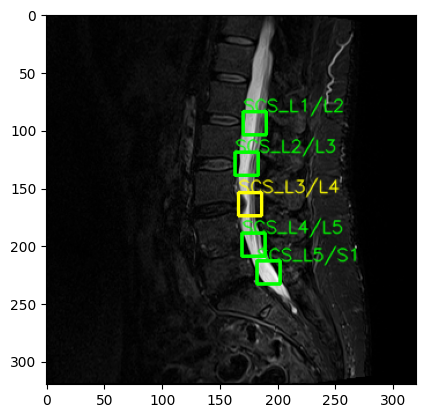

In [20]:
plt.imshow(img)
plt.show()

In [21]:
# label_df[['study_id', 'series_id']].drop_duplicates()

In [22]:
def read_dcm(src_path):
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() +1e-6) * 255
    image = np.stack([image]*3, axis=-1).astype('uint8')
    return image

In [23]:
filtered_df = label_df[label_df.condition.map(lambda x: x in CONDITIONS)]

In [24]:
label2id = {}
id2label = {}
i = 0
for cond in CONDITIONS:
    for level in LEVELS:
        for severity in SEVERITIES:
            cls_ = f"{cond.lower().replace(' ', '_')}_{level}_{severity.lower()}"
            label2id[cls_] = i
            id2label[i] = cls_
            i+=1

In [25]:
id2label

{0: 'left_neural_foraminal_narrowing_l1_l2_normal/mild',
 1: 'left_neural_foraminal_narrowing_l1_l2_moderate',
 2: 'left_neural_foraminal_narrowing_l1_l2_severe',
 3: 'left_neural_foraminal_narrowing_l2_l3_normal/mild',
 4: 'left_neural_foraminal_narrowing_l2_l3_moderate',
 5: 'left_neural_foraminal_narrowing_l2_l3_severe',
 6: 'left_neural_foraminal_narrowing_l3_l4_normal/mild',
 7: 'left_neural_foraminal_narrowing_l3_l4_moderate',
 8: 'left_neural_foraminal_narrowing_l3_l4_severe',
 9: 'left_neural_foraminal_narrowing_l4_l5_normal/mild',
 10: 'left_neural_foraminal_narrowing_l4_l5_moderate',
 11: 'left_neural_foraminal_narrowing_l4_l5_severe',
 12: 'left_neural_foraminal_narrowing_l5_s1_normal/mild',
 13: 'left_neural_foraminal_narrowing_l5_s1_moderate',
 14: 'left_neural_foraminal_narrowing_l5_s1_severe',
 15: 'right_neural_foraminal_narrowing_l1_l2_normal/mild',
 16: 'right_neural_foraminal_narrowing_l1_l2_moderate',
 17: 'right_neural_foraminal_narrowing_l1_l2_severe',
 18: 'right

In [26]:
train_df = filtered_df[filtered_df.fold != FOLD]
val_df = filtered_df[filtered_df.fold == FOLD]

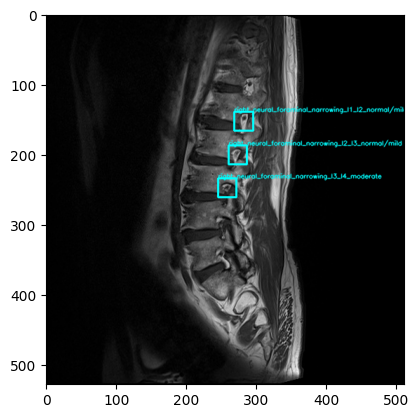

In [27]:
# # test generated annotations

_IM_DIR = f'{DATA_DIR}/images/train'
_ANN_DIR = f'{DATA_DIR}/labels/train'
name = np.random.choice(os.listdir(_IM_DIR))[:-4]

im = plt.imread(os.path.join(_IM_DIR, name+'.jpg')).copy()
H,W = im.shape[:2]
anns = np.loadtxt(os.path.join(_ANN_DIR, name+'.txt')).reshape(-1, 5)

for _cls, x,y,w,h in anns.tolist():
    x *= W
    y *= H
    w *= W
    h *= H
    x1 = int(x-w/2)
    x2 = int(x+w/2)
    y1 = int(y-h/2)
    y2 = int(y+h/2)
    label = id2label[_cls]
    
#     if _cls == 0:
#         c = (255,0,0)
#     elif _cls == 1:
#         c = (0,255,0)
#     else:
#         c = (255,255,0)
    c = (0,255,255)

    im = cv2.rectangle(im, (x1,y1), (x2,y2), c, 2)
    cv2.putText(im, label, (x1,y1), fontFace, 0.3, c, 1, cv2.LINE_AA)


plt.imshow(im)

In [28]:
# ls data_fold0/labels/val

In [29]:
# os.path.join(_ANN_DIR, name+'.txt')

In [30]:
# cat 'train_fold0/labels/404602713_1230697721_12.txt'

In [31]:
# Install the ultralytics package from GitHub
!pip install git+https://github.com/ultralytics/ultralytics.git@main

  Cloning https://github.com/ultralytics/ultralytics.git (to revision main) to /tmp/pip-req-build-3fpxtj_6
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/ultralytics.git /tmp/pip-req-build-3fpxtj_6
  Resolved https://github.com/ultralytics/ultralytics.git to commit 28eb65694c69141072f12ec0098ea421e067d867
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for ultralytics: filename=ultralytics-8.3.7-py3-none-any.whl size=882982 sha256=8fc6e806510f0dabd7c761791935ec78c92ae6cdd9d1edf0130179bc9cad8197
  Stored in directory: /tmp/pip-ephem-wheel-cache-a1mqu5tw/wheels/60/db/e5/6abbdd13b4e3d5e2fdcd87690cd8738f842eeb37142fdccb5b
Successfully built ultralytics


In [32]:
for k, v in id2label.items():
    print(f'{k}: {v}')

0: left_neural_foraminal_narrowing_l1_l2_normal/mild
1: left_neural_foraminal_narrowing_l1_l2_moderate
2: left_neural_foraminal_narrowing_l1_l2_severe
3: left_neural_foraminal_narrowing_l2_l3_normal/mild
4: left_neural_foraminal_narrowing_l2_l3_moderate
5: left_neural_foraminal_narrowing_l2_l3_severe
6: left_neural_foraminal_narrowing_l3_l4_normal/mild
7: left_neural_foraminal_narrowing_l3_l4_moderate
8: left_neural_foraminal_narrowing_l3_l4_severe
9: left_neural_foraminal_narrowing_l4_l5_normal/mild
10: left_neural_foraminal_narrowing_l4_l5_moderate
11: left_neural_foraminal_narrowing_l4_l5_severe
12: left_neural_foraminal_narrowing_l5_s1_normal/mild
13: left_neural_foraminal_narrowing_l5_s1_moderate
14: left_neural_foraminal_narrowing_l5_s1_severe
15: right_neural_foraminal_narrowing_l1_l2_normal/mild
16: right_neural_foraminal_narrowing_l1_l2_moderate
17: right_neural_foraminal_narrowing_l1_l2_severe
18: right_neural_foraminal_narrowing_l2_l3_normal/mild
19: right_neural_foraminal_n

In [33]:
ls

__notebook__.ipynb  data_fold0/


In [34]:
%%writefile yolo_scs.yaml
path: /kaggle/working/data_fold0 # dataset root dir
train: images/train  
val: images/val 
test: images/val 

# Classes
names:
    0: left_neural_foraminal_narrowing_l1_l2_normal/mild
    1: left_neural_foraminal_narrowing_l1_l2_moderate
    2: left_neural_foraminal_narrowing_l1_l2_severe
    3: left_neural_foraminal_narrowing_l2_l3_normal/mild
    4: left_neural_foraminal_narrowing_l2_l3_moderate
    5: left_neural_foraminal_narrowing_l2_l3_severe
    6: left_neural_foraminal_narrowing_l3_l4_normal/mild
    7: left_neural_foraminal_narrowing_l3_l4_moderate
    8: left_neural_foraminal_narrowing_l3_l4_severe
    9: left_neural_foraminal_narrowing_l4_l5_normal/mild
    10: left_neural_foraminal_narrowing_l4_l5_moderate
    11: left_neural_foraminal_narrowing_l4_l5_severe
    12: left_neural_foraminal_narrowing_l5_s1_normal/mild
    13: left_neural_foraminal_narrowing_l5_s1_moderate
    14: left_neural_foraminal_narrowing_l5_s1_severe
    15: right_neural_foraminal_narrowing_l1_l2_normal/mild
    16: right_neural_foraminal_narrowing_l1_l2_moderate
    17: right_neural_foraminal_narrowing_l1_l2_severe
    18: right_neural_foraminal_narrowing_l2_l3_normal/mild
    19: right_neural_foraminal_narrowing_l2_l3_moderate
    20: right_neural_foraminal_narrowing_l2_l3_severe
    21: right_neural_foraminal_narrowing_l3_l4_normal/mild
    22: right_neural_foraminal_narrowing_l3_l4_moderate
    23: right_neural_foraminal_narrowing_l3_l4_severe
    24: right_neural_foraminal_narrowing_l4_l5_normal/mild
    25: right_neural_foraminal_narrowing_l4_l5_moderate
    26: right_neural_foraminal_narrowing_l4_l5_severe
    27: right_neural_foraminal_narrowing_l5_s1_normal/mild
    28: right_neural_foraminal_narrowing_l5_s1_moderate
    29: right_neural_foraminal_narrowing_l5_s1_severe

Writing yolo_scs.yaml


In [35]:
import wandb
from wandb.integration.ultralytics import add_wandb_callback

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb")
wandb.login(key=secret_value_0)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


wandb: WARNING This integration is tested and supported for ultralytics v8.0.238 and below.
wandb: WARNING             Please report any issues to https://github.com/wandb/wandb/issues with the tag `yolov8`.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [36]:
# Initialize W&B run
wandb.init(
    project="lsdc_yolov8",
#     name=f"Demo_fold0",
#     tags=["baseline", "search-lr", ],
    group=";".join(CONDITIONS),
#     config={
#         "lr": LR,
#         "model-name":"xtremedistill-trim",
#         "dataset": [
#             "raw_compettion",
#             "MPWare",
#             "Nicholas"
#         ]
#     }
)

wandb: Currently logged in as: handududu. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.4
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241008_132948-quvlbkrw
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run upbeat-thunder-75
wandb: ⭐️ View project at https://wandb.ai/handududu/lsdc_yolov8
wandb: 🚀 View run at https://wandb.ai/handududu/lsdc_yolov8/runs/quvlbkrw


In [37]:
from ultralytics import YOLO


# Initialize YOLO Model
model = YOLO("yolov8s.pt")

# Add W&B callback for Ultralytics
add_wandb_callback(model, enable_model_checkpointing=True)

# Train/fine-tune your model
# At the end of each epoch, predictions on validation batches are logged
# to a W&B table with insightful and interactive overlays for
# computer vision tasks
model.train(project="lsdc_yolov8", data="yolo_scs.yaml", 
            epochs=EPOCHS, imgsz=OD_INPUT_SIZE, batch=BATCH_SIZE,augment = True,save_period = 1)

# Finish the W&B run
wandb.finish()

100%|██████████| 21.5M/21.5M [00:00<00:00, 270MB/s]


Ultralytics 8.3.7 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=yolo_scs.yaml, epochs=40, time=None, patience=100, batch=64, imgsz=384, save=True, save_period=1, cache=False, device=None, workers=8, project=lsdc_yolov8, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tr

100%|██████████| 755k/755k [00:00<00:00, 42.7MB/s]
2024-10-08 13:30:07,662	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-10-08 13:30:08,603	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=30

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 161MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/data_fold0/labels/train... 6621 images, 15 backgrounds, 0 corrupt: 100%|██████████| 6621/6621 [00:05<00:00, 1227.94it/s]


train: New cache created: /kaggle/working/data_fold0/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/data_fold0/labels/val... 1661 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1661/1661 [00:01<00:00, 1339.90it/s]


val: New cache created: /kaggle/working/data_fold0/labels/val.cache
Plotting labels to lsdc_yolov8/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000294, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 384 train, 384 val
Using 4 dataloader workers
Logging results to lsdc_yolov8/train
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      6.99G      2.657       5.34      1.221        116        384: 100%|██████████| 104/104 [00:45<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]

                   all       1661       3950     0.0308      0.185      0.032     0.0147
Ultralytics 8.3.7 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


YOLOv8s summary (fused): 168 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      7.01G      1.902      2.984     0.9623         88        384: 100%|██████████| 104/104 [00:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]

                   all       1661       3950      0.446       0.23      0.092     0.0413


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      7.01G      1.793      2.392     0.9485         78        384: 100%|██████████| 104/104 [00:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]

                   all       1661       3950      0.325      0.327      0.137     0.0652


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      6.99G      1.751      2.167     0.9416         91        384: 100%|██████████| 104/104 [00:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]

                   all       1661       3950      0.341      0.333      0.172     0.0769


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      6.99G      1.684      2.036     0.9324        110        384: 100%|██████████| 104/104 [00:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]

                   all       1661       3950      0.288      0.402      0.204     0.0975


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      6.98G      1.669      1.942      0.927        103        384: 100%|██████████| 104/104 [00:43<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]

                   all       1661       3950      0.344      0.452      0.223       0.11


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      6.99G      1.646      1.902     0.9287        101        384: 100%|██████████| 104/104 [00:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]

                   all       1661       3950      0.274      0.474       0.24      0.115


Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      7.01G      1.621       1.86     0.9205        102        384: 100%|██████████| 104/104 [00:43<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]

                   all       1661       3950      0.349      0.477       0.25      0.125


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      6.98G        1.6      1.805     0.9159        108        384: 100%|██████████| 104/104 [00:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]

                   all       1661       3950      0.321      0.457      0.258      0.124


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      6.98G      1.595      1.764      0.913         88        384: 100%|██████████| 104/104 [00:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]

                   all       1661       3950      0.368      0.472      0.336      0.163


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      6.99G        1.6      1.701     0.9154        103        384: 100%|██████████| 104/104 [00:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]

                   all       1661       3950      0.331       0.46      0.347      0.168


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40         7G      1.575      1.603     0.9116        112        384: 100%|██████████| 104/104 [00:43<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]

                   all       1661       3950      0.481      0.489        0.4      0.207


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      6.99G       1.56      1.527     0.9096         91        384: 100%|██████████| 104/104 [00:43<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]

                   all       1661       3950      0.467      0.543      0.435      0.215


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40         7G      1.562      1.512     0.9093        113        384: 100%|██████████| 104/104 [00:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]

                   all       1661       3950      0.414      0.551      0.435      0.216


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      6.99G      1.551      1.471     0.9053         85        384: 100%|██████████| 104/104 [00:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]

                   all       1661       3950      0.421      0.489      0.413      0.198


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      6.99G      1.539      1.459     0.9065         74        384: 100%|██████████| 104/104 [00:43<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]

                   all       1661       3950      0.477      0.537      0.445      0.214


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      7.01G      1.537      1.437     0.9073         96        384: 100%|██████████| 104/104 [00:43<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]

                   all       1661       3950      0.484      0.569       0.46       0.23


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      6.99G      1.514      1.408     0.9023         96        384: 100%|██████████| 104/104 [00:43<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]

                   all       1661       3950      0.483      0.555      0.461      0.228


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40         7G      1.529      1.395     0.9047         98        384: 100%|██████████| 104/104 [00:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]

                   all       1661       3950      0.444       0.56      0.475      0.239


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      6.99G       1.51      1.385     0.9025         95        384: 100%|██████████| 104/104 [00:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]

                   all       1661       3950      0.466      0.576      0.479      0.245


Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      7.01G      1.508      1.381     0.8991         96        384: 100%|██████████| 104/104 [00:43<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]

                   all       1661       3950      0.472      0.547      0.463      0.231


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40         7G      1.505      1.361     0.9014         92        384: 100%|██████████| 104/104 [00:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]

                   all       1661       3950      0.468      0.552      0.467       0.24


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      6.92G      1.499      1.358      0.902         87        384: 100%|██████████| 104/104 [00:43<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]

                   all       1661       3950      0.512      0.557      0.474      0.245


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40         7G      1.482       1.34     0.8981         72        384: 100%|██████████| 104/104 [00:43<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]

                   all       1661       3950      0.489      0.552      0.472      0.244


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      6.99G        1.5      1.342     0.9019        107        384: 100%|██████████| 104/104 [00:43<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]

                   all       1661       3950       0.46      0.534      0.464      0.235


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      6.99G      1.481      1.329     0.8985         78        384: 100%|██████████| 104/104 [00:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]

                   all       1661       3950      0.545      0.534      0.479      0.244


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      6.99G      1.484      1.319     0.8972         86        384: 100%|██████████| 104/104 [00:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]

                   all       1661       3950      0.469      0.591      0.481      0.247


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40         7G      1.461      1.304     0.8945        132        384: 100%|██████████| 104/104 [00:43<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]

                   all       1661       3950      0.468      0.562       0.48      0.242


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      6.99G      1.474      1.305     0.8983         68        384: 100%|██████████| 104/104 [00:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]

                   all       1661       3950      0.481      0.554      0.482      0.251


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40         7G      1.464      1.289      0.895        107        384: 100%|██████████| 104/104 [00:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]

                   all       1661       3950       0.48      0.563      0.474      0.245


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      6.96G      1.453      1.232     0.9223         73        384: 100%|██████████| 104/104 [00:44<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]

                   all       1661       3950      0.445      0.587      0.475      0.248


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      6.96G      1.435      1.219     0.9196         91        384: 100%|██████████| 104/104 [00:43<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]

                   all       1661       3950      0.463       0.57      0.477       0.25


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      6.96G       1.42      1.199     0.9167         70        384: 100%|██████████| 104/104 [00:43<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]

                   all       1661       3950       0.48      0.561      0.486      0.254


Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      6.96G      1.416      1.192     0.9129         63        384: 100%|██████████| 104/104 [00:43<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]

                   all       1661       3950      0.477      0.568      0.486      0.253


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      6.96G      1.414      1.185     0.9143         69        384: 100%|██████████| 104/104 [00:43<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]

                   all       1661       3950      0.464      0.569      0.481      0.254


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      6.96G      1.393      1.183     0.9081         66        384: 100%|██████████| 104/104 [00:43<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]

                   all       1661       3950      0.469      0.557       0.48      0.251


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      6.96G      1.398      1.176     0.9103         65        384: 100%|██████████| 104/104 [00:43<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]

                   all       1661       3950      0.482       0.56      0.489      0.253


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      6.98G      1.393      1.172     0.9085         82        384: 100%|██████████| 104/104 [00:43<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]

                   all       1661       3950      0.494      0.546      0.482      0.251


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      6.96G      1.382      1.157     0.9072         70        384: 100%|██████████| 104/104 [00:43<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]

                   all       1661       3950      0.477       0.55      0.481      0.251


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      6.98G      1.376      1.155     0.9077         79        384: 100%|██████████| 104/104 [00:43<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]

                   all       1661       3950      0.486      0.553      0.483      0.252


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


40 epochs completed in 0.854 hours.
Optimizer stripped from lsdc_yolov8/train/weights/last.pt, 19.9MB
Optimizer stripped from lsdc_yolov8/train/weights/best.pt, 19.9MB

Validating lsdc_yolov8/train/weights/best.pt...
Ultralytics 8.3.7 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 186 layers, 9,839,274 parameters, 0 gradients, 23.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:17<00:00,  1.33s/it]


                   all       1661       3950      0.465      0.581      0.484      0.251
left_neural_foraminal_narrowing_l1_l2_normal/mild        380        380      0.601      0.889      0.788      0.402
left_neural_foraminal_narrowing_l1_l2_moderate         15         15      0.359      0.533      0.348      0.199
left_neural_foraminal_narrowing_l2_l3_normal/mild        358        358      0.622      0.885      0.743      0.405
left_neural_foraminal_narrowing_l2_l3_moderate         34         34      0.411        0.5      0.382        0.2
left_neural_foraminal_narrowing_l2_l3_severe          3          3          1          0     0.0716     0.0424
left_neural_foraminal_narrowing_l3_l4_normal/mild        305        305      0.605      0.845      0.738      0.403
left_neural_foraminal_narrowing_l3_l4_moderate         83         83      0.315       0.53      0.337      0.162
left_neural_foraminal_narrowing_l3_l4_severe          7          7      0.414      0.571      0.504      0.243
le

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Speed: 0.1ms preprocess, 4.3ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to lsdc_yolov8/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▃▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg1 ▃▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg2 ▃▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:        metrics/mAP50(B) ▁▂▃▃▄▄▄▄▄▆▆▇▇▇▇▇████████████████████████
wandb:     metrics/mAP50-95(B) ▁▂▂▃▃▄▄▄▄▅▅▇▇▇▆▇▇▇██▇███▇███████████████
wandb:    metrics/precision(B) ▁▇▅▅▅▅▄▅▅▆▅▇▇▆▆▇▇▇▇▇▇▇█▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇
wandb:       metrics/recall(B) ▁▂▃▄▅▆▆▆▆▆▆▆▇▇▆▇█▇▇█▇▇▇▇▇▇██▇███▇██▇▇▇▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/cls_loss █▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/dfl_loss █▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁
wandb:            val/box_loss █▆▅▆▅▃▄▃▃▅▄▂▃▃▅▅▂▄▂▁▃▁▁▂▂▂▂▃▁▂▂▁▁▁▁

right_neural_foraminal_narrowing_l1_l2_normal/mild
right_neural_foraminal_narrowing_l2_l3_moderate
right_neural_foraminal_narrowing_l3_l4_normal/mild


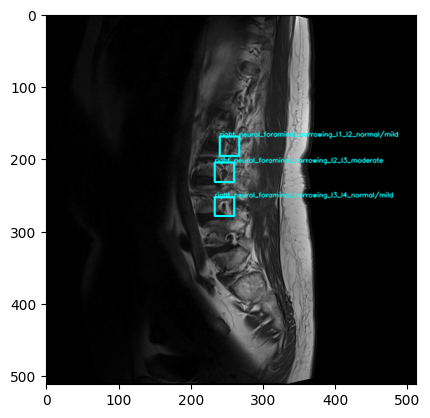

In [38]:
# # test generated annotations

_IM_DIR = f'{DATA_DIR}/images/val'
_ANN_DIR = f'{DATA_DIR}/labels/val'
name = np.random.choice(os.listdir(_IM_DIR))[:-4]

path = os.path.join(_IM_DIR, name+'.jpg')

im = plt.imread(path).copy()
H,W = im.shape[:2]
anns = np.loadtxt(os.path.join(_ANN_DIR, name+'.txt')).reshape(-1, 5)

for _cls, x,y,w,h in anns.tolist():
    x *= W
    y *= H
    w *= W
    h *= H
    x1 = int(x-w/2)
    x2 = int(x+w/2)
    y1 = int(y-h/2)
    y2 = int(y+h/2)
    label = id2label[_cls]
    print(label)
    
#     if _cls == 0:
#         c = (255,0,0)
#     elif _cls == 1:
#         c = (0,255,0)
#     else:
#         c = (255,255,0)
    c = (0,255,255)

    im = cv2.rectangle(im, (x1,y1), (x2,y2), c, 2)
    cv2.putText(im, label, (x1,y1), fontFace, 0.3, c, 1, cv2.LINE_AA)


plt.imshow(im)

In [39]:
# Initialize YOLO Model
model = YOLO(glob.glob("lsdc_yolov8/*/weights/best.pt")[0])

# Add W&B callback for Ultralytics
# add_wandb_callback(model, enable_model_checkpointing=True)

# Perform prediction which automatically logs to a W&B Table
# with interactive overlays for bounding boxes, segmentation masks
out = model.predict([path], save=True, conf=0.2)

# Finish the W&B run
wandb.finish()


0: 384x384 2 right_neural_foraminal_narrowing_l4_l5_normal/milds, 9.5ms
Speed: 2.4ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 384)
Results saved to runs/detect/predict


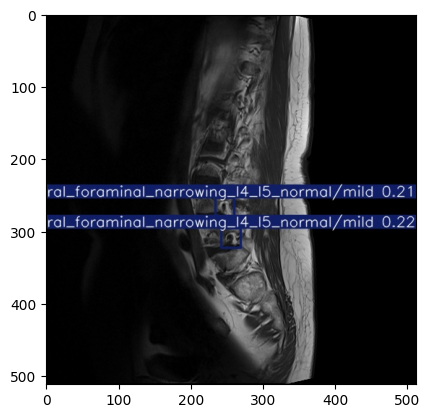

In [40]:
im = plt.imread(glob.glob(f'{out[0].save_dir}/*.jpg')[0])
plt.imshow(im)